## Tutorial 08 - Non linear Parabolic problem
**_Keywords: exact parametrized functions, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider the FitzHugh-Nagumo (F-N) system. The F-N system is used to describe neuron excitable systems. The nonlinear parabolic problem for the F-N system is defined on the interval $I=[0,L]$. Let $x\in I$, $t\geq0$

$$\begin{cases} 
    \varepsilon u_t(x,t) =\varepsilon^2u_{xx}(x,t)+g(u(x,t))-\omega(x,t)+c, & x\in I,\quad t\geq 0, \\
    \omega_t(x,t) =bu(x,t)-\gamma\omega(x,t)+c, & x\in I,\quad t\geq 0, \\
    u(x,0) = 0,\quad\omega(x,0)=0, & x\in I, \\
    u_x(0,t)=-i_0(t),\quad u_x(L,t)=0, & t\geq 0,
\end{cases}$$

where the nonlinear function is defined by
$$g(u) = u(u-0.1)(1-u)$$

and the parameters are given by $L = 1$, $\varepsilon = 0.015$, $b = 0.5$, $\gamma = 2$, and $c = 0.05$. The stimulus $i_0(t)=50000t^3\exp(-15t)$. The variables $u$ and $\omega$ represent the $\textit{voltage}$ and the $\textit{recovery of voltage}$, respectively. 

In order to obtain an exact solution of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Formulation for the F-N system

Let $u,\omega$ the solutions in the domain $I$.

For this problem we want to find $\boldsymbol{u}=(u,\omega)$ such that

$$
m\left(\partial_t\boldsymbol{u}(t),\boldsymbol{v}\right)+a\left(\boldsymbol{u}(t),\boldsymbol{v}\right)+c\left(u(t),v\right)=f(\boldsymbol{v})\quad \forall \boldsymbol{v}=(v,\tilde{v}), \text{ with }v,\tilde{v} \in\mathbb{V},\quad\forall t\geq0
$$



where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in L^2(I) : v|_{\{0\}}=0\}
$$
* the bilinear form $m(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$m(\partial\boldsymbol{u}(t), \boldsymbol{v})=\varepsilon\int_{I}\frac{\partial u}{\partial t}v \ d\boldsymbol{x} \ + \ \int_{I}\frac{\partial\omega}{\partial t}\tilde{v} \ d\boldsymbol{x},$$
* the bilinear form $a(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}(t), \boldsymbol{v})=\varepsilon^2\int_{I} \nabla u\cdot \nabla v \ d\boldsymbol{x}+\int_{I}\omega v \ d\boldsymbol{x} \ - \ b\int_{I} u\tilde{v} \ d\boldsymbol{x}+\gamma\int_{I}\omega\tilde{v} \ d\boldsymbol{x},$$
* the bilinear form $c(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v)=-\int_{I} g(u)v \ d\boldsymbol{x},$$
* the linear form $f(\cdot): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v})= c\int_{I}\left(v+\tilde{v}\right) \ d\boldsymbol{x} \ + \ \varepsilon^2i_0(t)\int_{\{0\}}v \ d\boldsymbol{s}.$$

The output of interest $s(t)$ is given by
$$s(t) = c\int_{I}\left[u(t)+\omega(t)\right] \ d\boldsymbol{x} \ + \ \varepsilon^2i_0(t)\int_{\{0\}}u(t) \ d\boldsymbol{s} $$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

We set the variables $u:=u_1$, $\omega:=u_2$ and the test functions $v:=v_1$, $\tilde{v}:=v_2$.
For this problem the affine decomposition is straightforward:
    $$m(\boldsymbol{u},\boldsymbol{v})=\underbrace{\varepsilon}_{\Theta^{m}_0}\underbrace{\int_{I}u_1v_1 \ d\boldsymbol{x}}_{m_0(u_1,v_1)} \ + \ \underbrace{1}_{\Theta^{m}_1}\underbrace{\int_{I}u_2v_2 \ d\boldsymbol{x}}_{m_1(u_2,v_2)},$$
$$a(\boldsymbol{u},\boldsymbol{v})=\underbrace{\varepsilon^2}_{\Theta^{a}_0}\underbrace{\int_{I}\nabla u_1 \cdot \nabla v_1 \ d\boldsymbol{x}}_{a_0(u_1,v_1)} \ + \ \underbrace{1}_{\Theta^{a}_1}\underbrace{\int_{I}u_2v_1 \ d\boldsymbol{x}}_{a_1(u_2,v_1)} \ + \ \underbrace{-b}_{\Theta^{a}_2}\underbrace{\int_{I}u_1v_2 \ d\boldsymbol{x}}_{a_2(u_1,v_2)} \ + \ \underbrace{\gamma}_{\Theta^{a}_3}\underbrace{\int_{I}u_2v_2 \ d\boldsymbol{x}}_{a_3(u_2,v_2)},$$
$$c(u,v)=\underbrace{-1}_{\Theta^{c}_0}\underbrace{\int_{I}g(u_1)v_1 \ d\boldsymbol{x}}_{c_0(u_1,v_1)},$$
$$f(\boldsymbol{v}) = \underbrace{c}_{\Theta^{f}_0} \underbrace{\int_{I}(v_1 + v_2) \ d\boldsymbol{x}}_{f_0(v_1,v_2)} \ + \ \underbrace{\varepsilon^2i_0(t)}_{\Theta^{f}_1} \underbrace{\int_{\{0\}} v_1 \ d\boldsymbol{s}}_{f_1(v_1)}.$$
We will implement the numerical discretization of the problem in the class
```
class FitzHughNagumo(NonlinearParabolicProblem):
```
by specifying the coefficients $\Theta^{m}_*$, $\Theta^{a}_*$, $\Theta^{c}_*$ and $\Theta^{f}_*$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $m_*(\boldsymbol{u}, \boldsymbol{v})$, $a_*(\boldsymbol{u}, \boldsymbol{v})$, $c_*(u, v)$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
@ExactParametrizedFunctions()
class FitzHughNagumo(NonlinearParabolicProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearParabolicProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        (self.du1, self.du2) = split(self.du)
        self.u = self._solution
        (self.u1, self.u2) = split(self.u)
        self.v = TestFunction(V)
        (self.v1, self.v2) = split(self.v)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Problem coefficients
        self.epsilon = 0.015
        self.b = 0.5
        self.gamma = 2
        self.c = 0.05
        self.i0 = lambda t: 50000 * t**3 * exp(-15 * t)
        self.g = lambda v: v * (v - 0.1) * (1 - v)
        # Customize time stepping parameters
        self._time_stepping_parameters.update({
            "report": True,
            "snes_solver": {
                "linear_solver": "umfpack",
                "maximum_iterations": 20,
                "report": True
            }
        })

    # Return custom problem name
    def name(self):
        return "FitzHughNagumoExact"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        if term == "m":
            theta_m0 = self.epsilon
            theta_m1 = 1.
            return (theta_m0, theta_m1)
        elif term == "a":
            theta_a0 = self.epsilon**2
            theta_a1 = 1.
            theta_a2 = - self.b
            theta_a3 = self.gamma
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "c":
            theta_c0 = - 1.
            return (theta_c0,)
        elif term == "f":
            t = self.t
            theta_f0 = self.c
            theta_f1 = self.epsilon**2 * self.i0(t)
            return (theta_f0, theta_f1)
        elif term == "s":
            t = self.t
            theta_s0 = self.c
            theta_s1 = self.epsilon**2 * self.i0(t)
            return (theta_s0, theta_s1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        (v1, v2) = (self.v1, self.v2)
        dx = self.dx
        if term == "m":
            (u1, u2) = (self.du1, self.du2)
            m0 = u1 * v1 * dx
            m1 = u2 * v2 * dx
            return (m0, m1)
        elif term == "a":
            (u1, u2) = (self.du1, self.du2)
            a0 = inner(grad(u1), grad(v1)) * dx
            a1 = u2 * v1 * dx
            a2 = u1 * v2 * dx
            a3 = u2 * v2 * dx
            return (a0, a1, a2, a3)
        elif term == "c":
            u1 = self.u1
            c0 = self.g(u1) * v1 * dx
            return (c0,)
        elif term == "f":
            ds = self.ds
            f0 = v1 * dx + v2 * dx
            f1 = v1 * ds(1)
            return (f0, f1)
        elif term == "s":
            (v1, v2) = (self.v1, self.v2)
            ds = self.ds
            s0 = v1 * dx + v2 * dx
            s1 = v1 * ds(1)
            return (s0, s1)
        elif term == "inner_product":
            (u1, u2) = (self.du1, self.du2)
            x0 = inner(grad(u1), grad(v1)) * dx + u2 * v2 * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearParabolicProblem)
def CustomizeReducedNonlinearParabolic(ReducedNonlinearParabolic_Base):
    class ReducedNonlinearParabolic(ReducedNonlinearParabolic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearParabolic_Base.__init__(self, truth_problem, **kwargs)
            self._time_stepping_parameters.update({
                "report": True,
                "nonlinear_solver": {
                    "report": True,
                    "line_search": "wolfe"
                }
            })

    return ReducedNonlinearParabolic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/interval.xml")
subdomains = MeshFunction("size_t", mesh, "data/interval_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/interval_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1, dim=2)

### 4.3. Allocate an object of the FitzHughNagumo class

In [5]:
problem = FitzHughNagumo(V, subdomains=subdomains, boundaries=boundaries)
mu_range = []
problem.set_mu_range(mu_range)
problem.set_time_step_size(0.02)
problem.set_final_time(1)#8)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(1)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|M(\boldsymbol{\mu^{(i)}})\frac{\partial \operatorname{N}_W}{\partial t}(\boldsymbol{\mu^{(i)}}) + A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $M(\boldsymbol{\mu})$ is the mass matrix corresponding to the bilinear form $m$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$, $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$. The partial derivative $\frac{\partial \operatorname{N}_W}{\partial t}(\boldsymbol{\mu^{(i)}})$ is computed via automatic differentiation in PyTorch.

In [37]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=5, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=1)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [39]:
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.0001)
pinn_trainer.optimizer = optimizer
pinn_trainer.train()

6600 9078360.25986537
6700 8918826.04943107
6800 8806982.224630166
6900 8701519.502615474
7000 8596496.735197436
7100 8485778.459665334
7200 8366753.36000246
7300 8239959.707945355
7400 8133075.576141997
7500 9368264.242109332
7600 7930271.782493335
7700 7876913.18508012
7800 7776135.2321441015
7900 7858137.108458891
8000 7655920.483357438
8100 7560728.938975428
8200 7592276.875417173
8300 7449128.675296864
8400 8743897.0925698
8500 7333011.776578406
8600 7533760.8222251395
8700 7241022.896709782
8800 13904515.810374409
8900 7166672.25392747
9000 13582520.124180993
9100 12442222.265557345
9200 7034030.148258851
9300 8701433.0338823
9400 6976297.715158205
9500 7022943.952656756
9600 6927741.8895450635
9700 7914080.540617952
9800 6861426.473629233
9900 7033565.599035509
10000 6808596.092062296
10100 7536106.547469122
10200 6774285.479214077
10300 6815542.694361504
10400 6732227.266688015
10500 6729492.466614427
10600 6927228.83731266
10700 14669486.863473982
10800 6666690.664080593
10900

KeyboardInterrupt: 

In [ ]:
pinn_loss.operators['c'][0]

In [ ]:
from rbnics.backends.dolfin.evaluate import evaluate
problem.set_time(0.)
evaluate(problem.operator['c'][0])[:]

In [ ]:
pinn_net.time_augmented_mu.shape, pinn_loss.operators['c'].shape, 51*80

In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [25]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [26]:
pdnn_trainer.train()

0 1.1120416652934455
100 0.2465863515659072
200 0.20700066563207734
300 0.156653093920313
400 0.08740919566305005
500 0.04651033400752607
600 0.02884896928879674
700 0.01894865625604336
800 0.01239538029398201
900 0.008123588974541199
1000 0.00554128941898068
1100 0.004018659113782234
1200 0.0030858136168802866
1300 0.00247949861306651
1400 0.0020617370963177096
1500 0.0017596741313937185
1600 0.001532900808596332
1700 0.001356245545543918
1800 0.0012131374169834118
1900 0.0010931400724023298
2000 0.0009888877675225632
2100 0.0008965787778174994
2200 0.0008132856263257961
2300 0.0007372662406695966
2400 0.0006673032985050659
2500 0.0006023784338514429
2600 0.0005416955535493828
2700 0.00048473673068276065
2800 0.0004316187570168542
2900 0.00038163197250783967
3000 0.0003360184788467969
3100 0.00029487003338601257
3200 0.00025834421383574873
3300 0.00022649023604987055
3400 0.00019868201276635166
3500 0.00017484887374849819
3600 0.0001539021089358676
3700 0.00013580497792764896
3800 0.0

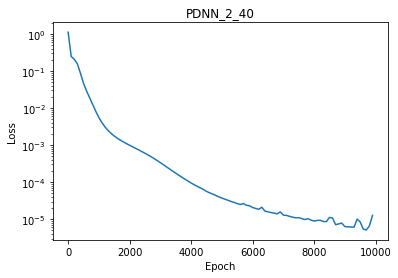

In [27]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [21]:
reduction_method.initialize_testing_set(1)
reduction_method.error_analysis()

=            FitzHughNagumoExact POD-Galerkin error analysis begins            =

###################################### 0 #######################################
# t = 0.02
0:  |F(x)| = 0.00141442; step 1
1:  |F(x)| = 1.91883e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.04
0:  |F(x)| = 0.00120925; step 1
1:  |F(x)| = 1.39355e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.06
0:  |F(x)| = 0.00117128; step 1
1:  |F(x)| = 1.2459e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.08
0:  |F(x)| = 0.00124168; step 1
1:  |F(x)| = 1.23218e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.1
0:  |F(x)| = 0.00134816; step 1
1:  |F(x)| = 1.04936e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.12
0:  |F(x)| = 0.00122348; step 1
1:  |F(x)| = 2.60837e-07; step 1
scipy solver converged in 3 iterations.
# t = 0.14
0:  |F(x)| = 0.00012378; step 1
1:  |F(x)| = 6.17254e-09; step 1
scipy solver converged in 3 iterations.
# t = 0.16
0:  |F(x)| = 0.0

/Users/maxhirsch/opt/anaconda3/envs/MLniCS/lib/python3.10/site-packages/scipy/optimize/_nonlin.py:366: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


0:  |F(x)| = 6.93247e-12; step 1
scipy solver converged in 2 iterations.
# t = 1
0:  |F(x)| = 4.37721e-12; step 1
scipy solver converged in 2 iterations.
# t = 0.02
0:  |F(x)| = 0.0113328; step 1
1:  |F(x)| = 6.4274e-05; step 1
2:  |F(x)| = 2.0945e-09; step 1
scipy solver converged in 4 iterations.
# t = 0.04
0:  |F(x)| = 0.0107468; step 1
1:  |F(x)| = 6.22319e-05; step 1
2:  |F(x)| = 2.10585e-09; step 1
scipy solver converged in 4 iterations.
# t = 0.06
0:  |F(x)| = 0.0128164; step 1
1:  |F(x)| = 8.13986e-05; step 1
2:  |F(x)| = 3.25693e-09; step 1
scipy solver converged in 4 iterations.
# t = 0.08
0:  |F(x)| = 0.0157677; step 1
1:  |F(x)| = 3.35655e-05; step 1
2:  |F(x)| = 1.14453e-10; step 1
scipy solver converged in 4 iterations.
# t = 0.1
0:  |F(x)| = 0.017024; step 1
1:  |F(x)| = 0.000157968; step 1
2:  |F(x)| = 1.30163e-08; step 1
scipy solver converged in 4 iterations.
# t = 0.12
0:  |F(x)| = 0.167888; step 1
1:  |F(x)| = 0.0104302; step 1
2:  |F(x)| = 4.76279e-05; step 1
3:  |

# t = 0.3
0:  |F(x)| = 0.000465483; step 1
1:  |F(x)| = 5.32045e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.32
0:  |F(x)| = 0.000479754; step 1
1:  |F(x)| = 5.88595e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.34
0:  |F(x)| = 0.000480505; step 1
1:  |F(x)| = 6.14755e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.36
0:  |F(x)| = 0.000474171; step 1
1:  |F(x)| = 6.21759e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.38
0:  |F(x)| = 0.000464045; step 1
1:  |F(x)| = 6.16233e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.4
0:  |F(x)| = 0.000451889; step 1
1:  |F(x)| = 6.02384e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.42
0:  |F(x)| = 0.000438716; step 1
1:  |F(x)| = 5.83173e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.44
0:  |F(x)| = 0.000425147; step 1
1:  |F(x)| = 5.60824e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.46
0:  |F(x)| = 0.00041159; step 1
1:  |F(x)| = 5.37036e-0

# t = 0.66
0:  |F(x)| = 0.000308959; step 1
1:  |F(x)| = 3.64582e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.68
0:  |F(x)| = 0.000303592; step 1
1:  |F(x)| = 3.5987e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.7
0:  |F(x)| = 0.000299228; step 1
1:  |F(x)| = 3.57478e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.72
0:  |F(x)| = 0.000295936; step 1
1:  |F(x)| = 3.57622e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.74
0:  |F(x)| = 0.000293817; step 1
1:  |F(x)| = 3.60628e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.76
0:  |F(x)| = 0.000293003; step 1
1:  |F(x)| = 3.6698e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.78
0:  |F(x)| = 0.000293681; step 1
1:  |F(x)| = 3.77379e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.8
0:  |F(x)| = 0.000296101; step 1
1:  |F(x)| = 3.92846e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.82
0:  |F(x)| = 0.000300606; step 1
1:  |F(x)| = 4.14882e-08

scipy solver converged in 3 iterations.
# t = 0.02
0:  |F(x)| = 0.0448483; step 1
1:  |F(x)| = 0.000254574; step 1
2:  |F(x)| = 8.31484e-09; step 1
scipy solver converged in 4 iterations.
# t = 0.04
0:  |F(x)| = 0.0424441; step 1
1:  |F(x)| = 0.000247256; step 1
2:  |F(x)| = 8.60064e-09; step 1
scipy solver converged in 4 iterations.
# t = 0.06
0:  |F(x)| = 0.0504305; step 1
1:  |F(x)| = 0.000321563; step 1
2:  |F(x)| = 1.33016e-08; step 1
scipy solver converged in 4 iterations.
# t = 0.08
0:  |F(x)| = 0.0584333; step 1
1:  |F(x)| = 0.000139259; step 1
2:  |F(x)| = 8.06104e-10; step 1
scipy solver converged in 4 iterations.
# t = 0.1
0:  |F(x)| = 0.0854313; step 1
1:  |F(x)| = 0.00353735; step 1
2:  |F(x)| = 2.06315e-05; step 1
3:  |F(x)| = 8.66411e-10; step 1
scipy solver converged in 5 iterations.
# t = 0.12
0:  |F(x)| = 0.61761; step 1
1:  |F(x)| = 0.0362632; step 1
2:  |F(x)| = 0.000146744; step 1
3:  |F(x)| = 2.43857e-09; step 1
scipy solver converged in 5 iterations.
# t = 0.14
0

1:  |F(x)| = 1.24219e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.32
0:  |F(x)| = 0.0108115; step 1
1:  |F(x)| = 1.38497e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.34
0:  |F(x)| = 0.0108172; step 1
1:  |F(x)| = 1.45433e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.36
0:  |F(x)| = 0.0106629; step 1
1:  |F(x)| = 1.47396e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.38
0:  |F(x)| = 0.0104235; step 1
1:  |F(x)| = 1.45895e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.4
0:  |F(x)| = 0.0101394; step 1
1:  |F(x)| = 1.42014e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.42
0:  |F(x)| = 0.00983379; step 1
1:  |F(x)| = 1.36607e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.44
0:  |F(x)| = 0.00952115; step 1
1:  |F(x)| = 1.3036e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.46
0:  |F(x)| = 0.00921075; step 1
1:  |F(x)| = 1.23804e-06; step 1
scipy solver converged in 3 iterations.
# t = 

scipy solver converged in 3 iterations.
# t = 0.68
0:  |F(x)| = 0.0102777; step 1
1:  |F(x)| = 1.21991e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.7
0:  |F(x)| = 0.0101354; step 1
1:  |F(x)| = 1.21125e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.72
0:  |F(x)| = 0.0100293; step 1
1:  |F(x)| = 1.21131e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.74
0:  |F(x)| = 0.00996267; step 1
1:  |F(x)| = 1.22102e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.76
0:  |F(x)| = 0.00994007; step 1
1:  |F(x)| = 1.24184e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.78
0:  |F(x)| = 0.00996754; step 1
1:  |F(x)| = 1.27589e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.8
0:  |F(x)| = 0.0100533; step 1
1:  |F(x)| = 1.32624e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.82
0:  |F(x)| = 0.0102086; step 1
1:  |F(x)| = 1.39734e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.84
0:  |F(x)| = 0.0104489; step

1:  |F(x)| = 0.0111592; step 1
2:  |F(x)| = 3.65581e-07; step 1
scipy solver converged in 4 iterations.
# t = 0.04
0:  |F(x)| = 1.85707; step 1
1:  |F(x)| = 0.0108419; step 1
2:  |F(x)| = 3.78801e-07; step 1
scipy solver converged in 4 iterations.
# t = 0.06
0:  |F(x)| = 2.2048; step 1
1:  |F(x)| = 0.0140643; step 1
2:  |F(x)| = 5.81222e-07; step 1
scipy solver converged in 4 iterations.
# t = 0.08
0:  |F(x)| = 2.54812; step 1
1:  |F(x)| = 0.00607465; step 1
2:  |F(x)| = 3.57723e-08; step 1
scipy solver converged in 4 iterations.
# t = 0.1
0:  |F(x)| = 3.73782; step 1
1:  |F(x)| = 0.155422; step 1
2:  |F(x)| = 0.000902395; step 1
3:  |F(x)| = 3.75829e-08; step 1
scipy solver converged in 5 iterations.
# t = 0.12
0:  |F(x)| = 26.9566; step 1
1:  |F(x)| = 1.5817; step 1
2:  |F(x)| = 0.00639285; step 1
3:  |F(x)| = 1.0624e-07; step 1
scipy solver converged in 5 iterations.
# t = 0.14
0:  |F(x)| = 21.1917; step 1
1:  |F(x)| = 0.731132; step 1
2:  |F(x)| = 0.000997312; step 1
3:  |F(x)| = 1

# t = 0.14
0:  |F(x)| = 21.1918; step 1
1:  |F(x)| = 0.731138; step 1
2:  |F(x)| = 0.000997306; step 1
3:  |F(x)| = 1.93293e-09; step 1
scipy solver converged in 5 iterations.
# t = 0.16
0:  |F(x)| = 6.14919; step 1
1:  |F(x)| = 0.0541268; step 1
2:  |F(x)| = 4.4638e-06; step 1
scipy solver converged in 4 iterations.
# t = 0.18
0:  |F(x)| = 1.10398; step 1
1:  |F(x)| = 0.00163957; step 1
2:  |F(x)| = 3.76731e-09; step 1
scipy solver converged in 4 iterations.
# t = 0.2
0:  |F(x)| = 0.104599; step 1
1:  |F(x)| = 1.47851e-05; step 1
2:  |F(x)| = 3.89149e-13; step 1
scipy solver converged in 4 iterations.
# t = 0.22
0:  |F(x)| = 0.00147915; step 1
1:  |F(x)| = 2.42783e-08; step 1
scipy solver converged in 3 iterations.
# t = 0.24
0:  |F(x)| = 0.0303786; step 1
1:  |F(x)| = 1.25038e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.26
0:  |F(x)| = 0.0584816; step 1
1:  |F(x)| = 4.60455e-06; step 1
scipy solver converged in 3 iterations.
# t = 0.28
0:  |F(x)| = 0.0738193; step 1
1:

scipy solver converged in 3 iterations.
# t = 0.26
0:  |F(x)| = 0.210209; step 1
1:  |F(x)| = 1.65502e-05; step 1
2:  |F(x)| = 2.31161e-13; step 1
scipy solver converged in 4 iterations.
# t = 0.28
0:  |F(x)| = 0.265339; step 1
1:  |F(x)| = 2.73763e-05; step 1
2:  |F(x)| = 6.11124e-13; step 1
scipy solver converged in 4 iterations.
# t = 0.3
0:  |F(x)| = 0.290165; step 1
1:  |F(x)| = 3.43377e-05; step 1
2:  |F(x)| = 3.88884e-13; step 1
scipy solver converged in 4 iterations.
# t = 0.32
0:  |F(x)| = 0.2987; step 1
1:  |F(x)| = 3.82525e-05; step 1
2:  |F(x)| = 9.06432e-13; step 1
scipy solver converged in 4 iterations.
# t = 0.34
0:  |F(x)| = 0.298805; step 1
1:  |F(x)| = 4.01312e-05; step 1
2:  |F(x)| = 1.5783e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.36
0:  |F(x)| = 0.294505; step 1
1:  |F(x)| = 4.0636e-05; step 1
2:  |F(x)| = 1.53561e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.38
0:  |F(x)| = 0.287869; step 1
1:  |F(x)| = 4.01903e-05; step 1
2:  |F(x)

1:  |F(x)| = 4.06325e-05; step 1
2:  |F(x)| = 1.46457e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.38
0:  |F(x)| = 0.287869; step 1
1:  |F(x)| = 4.01873e-05; step 1
2:  |F(x)| = 1.68454e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.4
0:  |F(x)| = 0.28001; step 1
1:  |F(x)| = 3.90953e-05; step 1
2:  |F(x)| = 1.56519e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.42
0:  |F(x)| = 0.27157; step 1
1:  |F(x)| = 3.7594e-05; step 1
2:  |F(x)| = 1.49993e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.44
0:  |F(x)| = 0.262942; step 1
1:  |F(x)| = 3.58715e-05; step 1
2:  |F(x)| = 1.24002e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.46
0:  |F(x)| = 0.25438; step 1
1:  |F(x)| = 3.4072e-05; step 1
2:  |F(x)| = 1.12529e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.48
0:  |F(x)| = 0.246056; step 1
1:  |F(x)| = 3.22992e-05; step 1
2:  |F(x)| = 9.53184e-13; step 1
scipy solver converged in 4 iterations.
# t = 0.5
0:  |F(x

# t = 0.46
0:  |F(x)| = 1.30564; step 1
1:  |F(x)| = 0.000174877; step 1
2:  |F(x)| = 5.95271e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.48
0:  |F(x)| = 1.26291; step 1
1:  |F(x)| = 0.000165778; step 1
2:  |F(x)| = 5.44981e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.5
0:  |F(x)| = 1.22199; step 1
1:  |F(x)| = 0.00015717; step 1
2:  |F(x)| = 4.34966e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.52
0:  |F(x)| = 1.18325; step 1
1:  |F(x)| = 0.000149264; step 1
2:  |F(x)| = 3.60447e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.54
0:  |F(x)| = 1.14695; step 1
1:  |F(x)| = 0.000142167; step 1
2:  |F(x)| = 3.0148e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.56
0:  |F(x)| = 1.11324; step 1
1:  |F(x)| = 0.000135914; step 1
2:  |F(x)| = 2.34414e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.58
0:  |F(x)| = 1.08222; step 1
1:  |F(x)| = 0.000130499; step 1
2:  |F(x)| = 2.21069e-12; step 1
scipy solver converge

# t = 0.56
0:  |F(x)| = 1.21325; step 1
1:  |F(x)| = 0.000148123; step 1
2:  |F(x)| = 2.79611e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.58
0:  |F(x)| = 1.17944; step 1
1:  |F(x)| = 0.000142223; step 1
2:  |F(x)| = 2.4036e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.6
0:  |F(x)| = 1.14864; step 1
1:  |F(x)| = 0.000137208; step 1
2:  |F(x)| = 2.58227e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.62
0:  |F(x)| = 1.12089; step 1
1:  |F(x)| = 0.000133043; step 1
2:  |F(x)| = 2.2054e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.64
0:  |F(x)| = 1.09626; step 1
1:  |F(x)| = 0.0001297; step 1
2:  |F(x)| = 2.39657e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.66
0:  |F(x)| = 1.07482; step 1
1:  |F(x)| = 0.000127163; step 1
2:  |F(x)| = 1.48305e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.68
0:  |F(x)| = 1.0567; step 1
1:  |F(x)| = 0.000125435; step 1
2:  |F(x)| = 2.22508e-12; step 1
scipy solver converged i

# t = 0.66
0:  |F(x)| = 3.78914; step 1
1:  |F(x)| = 0.000448296; step 1
2:  |F(x)| = 7.19565e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.68
0:  |F(x)| = 3.72525; step 1
1:  |F(x)| = 0.000442205; step 1
2:  |F(x)| = 6.9182e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.7
0:  |F(x)| = 3.67364; step 1
1:  |F(x)| = 0.000439064; step 1
2:  |F(x)| = 4.3632e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.72
0:  |F(x)| = 3.63517; step 1
1:  |F(x)| = 0.000439082; step 1
2:  |F(x)| = 8.87235e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.74
0:  |F(x)| = 3.61102; step 1
1:  |F(x)| = 0.000442601; step 1
2:  |F(x)| = 8.47043e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.76
0:  |F(x)| = 3.60282; step 1
1:  |F(x)| = 0.000450147; step 1
2:  |F(x)| = 7.47849e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.78
0:  |F(x)| = 3.61278; step 1
1:  |F(x)| = 0.000462487; step 1
2:  |F(x)| = 9.04282e-12; step 1
scipy solver converge

# t = 0.76
0:  |F(x)| = 3.60282; step 1
1:  |F(x)| = 0.000450147; step 1
2:  |F(x)| = 7.60892e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.78
0:  |F(x)| = 3.61278; step 1
1:  |F(x)| = 0.000462487; step 1
2:  |F(x)| = 5.8988e-12; step 1
scipy solver converged in 4 iterations.
# t = 0.8
0:  |F(x)| = 3.64387; step 1
1:  |F(x)| = 0.000480733; step 1
2:  |F(x)| = 1.08656e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.82
0:  |F(x)| = 3.70016; step 1
1:  |F(x)| = 0.000506505; step 1
2:  |F(x)| = 1.12208e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.84
0:  |F(x)| = 3.78723; step 1
1:  |F(x)| = 0.000542184; step 1
2:  |F(x)| = 1.1337e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.86
0:  |F(x)| = 3.91284; step 1
1:  |F(x)| = 0.000591348; step 1
2:  |F(x)| = 1.14788e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.88
0:  |F(x)| = 4.08796; step 1
1:  |F(x)| = 0.00065952; step 1
2:  |F(x)| = 1.91264e-11; step 1
scipy solver converged

# t = 0.86
0:  |F(x)| = 3.91284; step 1
1:  |F(x)| = 0.000591348; step 1
2:  |F(x)| = 1.4414e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.88
0:  |F(x)| = 4.08796; step 1
1:  |F(x)| = 0.00065952; step 1
2:  |F(x)| = 1.89301e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.9
0:  |F(x)| = 4.32844; step 1
1:  |F(x)| = 0.000755511; step 1
2:  |F(x)| = 2.20032e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.92
0:  |F(x)| = 4.65773; step 1
1:  |F(x)| = 0.000893932; step 1
2:  |F(x)| = 3.39791e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.94
0:  |F(x)| = 5.1115; step 1
1:  |F(x)| = 0.00110014; step 1
2:  |F(x)| = 5.25618e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.96
0:  |F(x)| = 5.74588; step 1
1:  |F(x)| = 0.00142052; step 1
2:  |F(x)| = 9.09668e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.98
0:  |F(x)| = 6.65241; step 1
1:  |F(x)| = 0.00194513; step 1
2:  |F(x)| = 1.75077e-10; step 1
scipy solver converged in

# t = 0.96
0:  |F(x)| = 5.74588; step 1
1:  |F(x)| = 0.00142052; step 1
2:  |F(x)| = 9.14708e-11; step 1
scipy solver converged in 4 iterations.
# t = 0.98
0:  |F(x)| = 6.65241; step 1
1:  |F(x)| = 0.00194513; step 1
2:  |F(x)| = 1.75464e-10; step 1
scipy solver converged in 4 iterations.
# t = 1
0:  |F(x)| = 7.98666; step 1
1:  |F(x)| = 0.00286063; step 1
2:  |F(x)| = 3.9613e-10; step 1
scipy solver converged in 4 iterations.

N 	gmean(error_u)        	max(error_u)          	gmean(relative_error_u)	max(relative_error_u) 
1 	1.0495134507073358    	1.0495134507073358    	4.804902186937118      	4.804902186937118     
2 	0.19636189087956812   	0.1963618908795681    	0.8402490827492856     	0.8402490827492856    
3 	0.15051512004266632   	0.1505151200426663    	0.7789626251077406     	0.7789626251077406    
4 	0.12163513012783826   	0.12163513012783823   	0.5976047196982025     	0.5976047196982025    
5 	0.027163045988681404  	0.02716304598868141   	0.32006883200357217    	0.3200688320035

#### 4.6.2 PINN Error Analysis

In [22]:
test_mu = torch.tensor(reduction_method.testing_set)

In [31]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=False
)

#################################### N = 20 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.6407612330269867	0.6407609930540171	0.0
mean	0.9111503834684547	0.9111502629529922	1.566215454006308e-05
max	1.6602127201566317	1.6602129325885766	3.700502891113269e-05


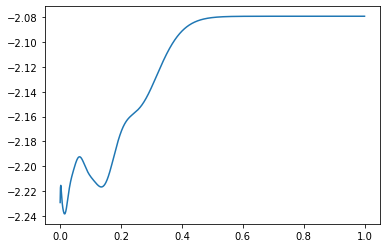

In [24]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, tuple(), input_normalization_pinn, output_normalization_pinn, t=0, component=0
)

#### 4.6.3 PDNN Error Analysis

In [30]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

#################################### N = 20 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0006691660196405486	0.0006687506762644861	0.0
mean	0.0014932113873781065	0.0014932417840680496	1.566215454006308e-05
max	0.006372142279814057	0.006372157244084907	3.700502891113269e-05


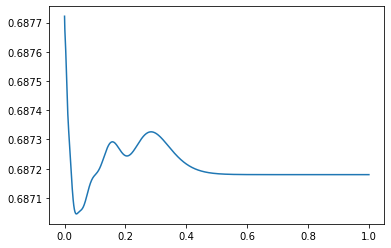

In [29]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, tuple(), input_normalization_pdnn, output_normalization_pdnn, t=0, component=0
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, tuple(), input_normalization_prnn, output_normalization_prnn, t=0, component=0
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, relative=False
)

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()